In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import time
from datetime import timedelta

import n_sphere
import tqdm
from enflows.distributions import StandardNormal, Uniform, DiagonalNormal
from enflows.transforms import Sigmoid, ScalarScale, ScalarShift, RandomPermutation, MaskedSumOfSigmoidsTransform
from enflows.transforms.normalization import ActNorm
from enflows.transforms.base import CompositeTransform, InverseTransform
from enflows.transforms.lipschitz import LipschitzDenseNetBuilder, iResBlock
from enflows.nn.nets.activations import Sin
from enflows.nn.nets import ResidualNet
from enflows.flows.base import Flow
from enflows.transforms.injective import FixedNorm, ConditionalFixedNorm, ConstrainedAnglesSigmoid, ResidualNetInput
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, LassoLarsIC, Ridge
from sklearn.datasets import load_diabetes
from sklearn.preprocessing import StandardScaler

In [4]:
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

In [5]:
def set_random_seeds (seed=1234):
    np.random.seed(seed)
    torch.manual_seed(seed)


In [6]:
def load_diabetes_dataset(device='cuda'):
    df = load_diabetes()
    scaler = StandardScaler()
    X_np = scaler.fit_transform(df.data)
    y_np = scaler.fit_transform(df.target.reshape(-1, 1))[:, 0]
    X_tensor = torch.from_numpy(X_np).float().to(device)
    y_tensor = torch.from_numpy(y_np).float().to(device)

    # compute regression parameters
    reg = LinearRegression().fit(X_np, y_np)
    r2_score = reg.score(X_np, y_np)
    print(f"R^2 score: {r2_score:.4f}")
    sigma_regr = np.sqrt(np.mean(np.square(y_np - X_np @ reg.coef_)))
    print(f"Sigma regression: {sigma_regr:.4f}")
    print(f"Norm coefficients: {np.linalg.norm(reg.coef_):.4f}")

    return X_tensor, y_tensor, X_np, y_np

In [61]:
def log_prior_beta(beta: torch.Tensor, lamb: torch.Tensor):

    log_prior = - lamb * beta.abs().sum(-1)
    log_prior_const = beta.shape[-1] * torch.log(0.5 * lamb)

    return log_prior + log_prior_const

def log_prior_ridge(beta: torch.Tensor, lamb: torch.Tensor):

    log_prior = - lamb * beta.square().sum(-1).sqrt()
    #log_prior_const = beta.shape[-1] * torch.log(0.5 * lamb)

    return log_prior #+ log_prior_const

def log_prior_angles(beta:torch.Tensor):
    beta_spherical = cartesian_to_spherical_torch(beta)
    

def log_likelihood(beta: torch.Tensor, sigma: torch.Tensor, X: torch.Tensor, y: torch.Tensor, ):

    eps = 1e-7
    log_lk = - 0.5 * (y - beta @ X.T).square().sum(-1) / (sigma**2 + eps)
    log_lk_const = - X.shape[0] * torch.log((sigma + eps) * np.sqrt(2. * np.pi))

    return log_lk + log_lk_const

def log_unnorm_posterior(beta: torch.Tensor, X: torch.Tensor, y: torch.Tensor,
                         lamb: torch.Tensor, sigma: torch.Tensor):

    log_likelihood_ = log_likelihood(beta, sigma, X, y)
    log_prior_beta_ = log_prior_beta(beta, lamb)
    
    return log_likelihood_ + log_prior_beta_

In [35]:
def spherical_to_cartesian_torch(arr):
    # meant for batches of vectors, i.e. arr.shape = (mb, n)
    
    assert arr.shape[1] >= 2
    r = arr[:, :1]
    angles = arr[:, 1:]
    
    sin_prods = torch.cumprod(torch.sin(angles), dim=1)
    x1 = r * torch.cos(angles[:, :1])
    xs = r * sin_prods[:, :-1] * torch.cos(angles[:, 1:])
    xn = r * sin_prods[:, -1:]

    return torch.cat((x1, xs, xn), dim=1)

def cartesian_to_spherical_torch(arr):
    # meant for batches of vectors, i.e. arr.shape = (mb, n)
    assert arr.shape[1] >= 2
    radius = torch.linalg.norm(arr, dim=1)
    flipped_cumsum = torch.cumsum(torch.flip(arr ** 2, dims=(1,)), dim=1)
    sqrt_sums = torch.flip(torch.sqrt(flipped_cumsum), dims=(1,))[:,:-1]
    angles = torch.acos(arr[:, :-1] / sqrt_sums)
    last_angle = ((arr[:,-1] >= 0).float() * angles[:, -1] + \
                (arr[:,-1] < 0).float() * (2 * np.pi - angles[:, -1]))

    return torch.cat((radius.unsqueeze(1), angles[:, :-1], last_angle.unsqueeze(1)), dim=1)

In [36]:
def build_flow_manifold (flow_dim, norm, q, n_layers=3, hidden_features=256, device='cuda'):
    # base distribution over flattened triangular matrix
    base_dist = StandardNormal(shape=[flow_dim-1])
    # low = torch.tensor(-1.).to(device)
    # high = torch.tensor(1.).to(device)
    # base_dist = Uniform(shape=[flow_dim-1], low=low, high=high)

    # Define an invertible transformation
    transformation_layers = []

    for _ in range(n_layers):
        #transformation_layers.append(RandomPermutation(features=flow_dim-1))

        
        
        transformation_layers.append(
            InverseTransform(
                MaskedSumOfSigmoidsTransform(features=flow_dim-1, hidden_features=hidden_features, num_blocks=3, n_sigmoids=30)
            )
        )
        
        transformation_layers.append(
           InverseTransform(
               ActNorm(features=flow_dim-1)
           )
        )


    # transformation_layers.append(
    #    transforms.InverseTransform(
    #            ScalarScale(scale=5, trainable=False)
    #        )
    # )

    # transformation_layers.append(
    #    InverseTransform(
    #            CompositeTransform([
    #                Sigmoid(),
    #                ScalarScale(scale=20, trainable=False),
    #                ScalarShift(shift=-10, trainable=False)]
    #            )
    #        )
    # )
    
    transformation_layers.append(
        InverseTransform(
                ConstrainedAnglesSigmoid(temperature=1, learn_temperature=False)
            )
    )
    
    
    transformation_layers.append(
        InverseTransform(
            FixedNorm(norm=norm, q=q)
        )
    )

    transformation_layers = transformation_layers[::-1]
    transform = CompositeTransform(transformation_layers)

    # combine into a flow
    flow = Flow(transform, base_dist).to(device)

    return flow

def build_cond_flow_lipshitz_manifold (flow_dim, norm, q, n_layers=3, hidden_features=256, device='cuda'):
    # base distribution over flattened triangular matrix
    base_dist = StandardNormal(shape=[flow_dim-1])

    densenet_builder = LipschitzDenseNetBuilder(input_channels=flow_dim-1,
                                                densenet_depth=5,
                                                activation_function=Sin(w0=30),
                                                lip_coeff=.97,
                                                )

    transform_layers = []
    for i in range(n_layers):
        transform_layers.append(InverseTransform(ActNorm(features=flow_dim-1)))
        transform_layers.append(InverseTransform(iResBlock(densenet_builder.build_network(), brute_force=False)))
    
    transform_layers.append(
        InverseTransform(
                ConstrainedAnglesSigmoid()
            )
    )
    transform_layers.append(
        InverseTransform(
            FixedNorm(norm=norm, q=q)
        )
    )

    transform_layers = transform_layers[::-1]
    transform = CompositeTransform(transform_layers)

    flow = Flow(transform, base_dist).to(device)

    return flow

In [37]:
def build_cond_flow_manifold (flow_dim, q, n_layers=3, context_features=16, hidden_features=256, device='cuda'):
    # base distribution over flattened triangular matrix
    base_dist = StandardNormal(shape=[flow_dim-1])

    # Define an invertible transformation
    transformation_layers = []

    for _ in range(n_layers):
        transformation_layers.append(RandomPermutation(features=flow_dim-1))

        transformation_layers.append(
            InverseTransform(
                MaskedSumOfSigmoidsTransform(features=flow_dim-1, hidden_features=hidden_features,
                                             context_features=context_features, num_blocks=5, n_sigmoids=30)
            )
        )
        
        transformation_layers.append(
            InverseTransform(
                ActNorm(features=flow_dim-1)
            )
        )

    transformation_layers.append(
        InverseTransform(
                ConstrainedAnglesSigmoid(temperature=1, learn_temperature=False)
            )
    )
    
    
    transformation_layers.append(
        InverseTransform(
            ConditionalFixedNorm(q=q)
        )
    )

    transformation_layers = transformation_layers[::-1]
    transform = CompositeTransform(transformation_layers)

    # define embedding (conditional) network
    embedding_net = ResidualNetInput(in_features=1, out_features=context_features, hidden_features=256,
                                    num_blocks=3, activation=torch.nn.functional.relu)

    # combine into a flow
    flow = Flow(transform, base_dist, embedding_net=embedding_net).to(device)
    
    return flow

In [38]:
def gen_cooling_schedule(T0, Tn, num_iter, scheme):
    def cooling_schedule(t):
        if t < num_iter:
            k = t / num_iter
            if scheme == 'exp_mult':
                alpha = Tn / T0
                return T0 * (alpha ** k)
            #elif scheme == 'log_mult':
            #    return T0 / (1 + alpha * math.log(1 + k))
            elif scheme == 'lin_mult':
                alpha = (T0 / Tn - 1)
                return T0 / (1 + alpha * k)
            elif scheme == 'quad_mult':
                alpha = (T0 / Tn - 1)
                return T0 / (1 + alpha * (k ** 2))
        else:
            return Tn
    return cooling_schedule

In [355]:
def train_cond_model(model, X, y, sigma, epochs=2_001, lr=1e-3, sample_size=1, context_size=1_000, norm_min_exp=-1, norm_max_exp=1., norm_min=-1, norm_max=1., T0=5, Tn=1e-2, iter_per_cool_step=20, device="cuda", **kwargs,):

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # set up cooling schedule
    num_iter = epochs // iter_per_cool_step
    cooling_function = gen_cooling_schedule(T0=T0, Tn=Tn, num_iter=num_iter - 1, scheme='exp_mult')

    loss, loss_T = [], []
    try:
        start_time = time.monotonic()
        for epoch in range(epochs):
            T = cooling_function(epoch // (epochs / num_iter))
            optimizer.zero_grad()
            
            rand_norm = torch.rand(context_size).to(device)
            # log_uniform_norm = 10 ** (rand_norm * (norm_max_exp - norm_min_exp) + norm_min_exp).view(-1, 1)
            uniform_norm = (rand_norm * (norm_max - norm_min) + norm_min).view(-1, 1)

            q_samples, q_log_prob = model.sample_and_log_prob(num_samples=sample_size, context=uniform_norm)
            if torch.any(torch.isnan(q_samples)): breakpoint()

            log_lik = log_likelihood(beta=q_samples, sigma=sigma, X=X, y=y)
            # log_lik = log_unnorm_posterior(beta=q_samples, sigma=sigma, X=X, y=y, lamb=torch.tensor(200.))
            # log_lik = uniform_p_norm(beta=q_log_prob)
            kl_div = torch.mean(q_log_prob - log_lik/ T)
            kl_div.backward()
            
            # entropy = torch.mean(q_log_prob)
            # entropy.backward()
            
            optimizer.step()

            # loss.append(torch.mean(q_log_prob_beta - log_lik).cpu().detach().numpy())
            loss.append(torch.mean(q_log_prob - log_lik).cpu().detach().numpy())
            loss_T.append(torch.mean(q_log_prob - log_lik/T).cpu().detach().numpy())
            print(f"Training loss at step {epoch}: {loss[-1]:.1f} and {loss_T[-1]:.1f} * (T = {T:.3f})")


    except KeyboardInterrupt:
        print("interrupted..")

    end_time = time.monotonic()
    time_diff = timedelta(seconds=end_time - start_time)
    print(f"Training took {time_diff} seconds")

    return model, loss, loss_T

In [356]:
def train_model(model, X, y, sigma, epochs=2_001, lr=1e-3, sample_size=1, device="cuda", **kwargs):

    # optimizer = torch.optim.Adam([{'params':model.parameters()}, {'params':log_sigma, 'lr':1e-2}], lr=lr)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    # scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

    loss = []
    try:
        start_time = time.monotonic()
        for epoch in range(epochs):
            model.train()
            
            optimizer.zero_grad()
            q_samples, q_log_prob = model.sample_and_log_prob(num_samples=sample_size)
            if torch.any(torch.isnan(q_samples)): breakpoint()
            
            log_lik = log_likelihood(beta=q_samples, sigma=sigma, X=X, y=y)
            # log_lik = uniform_p_norm(beta=q_log_prob)
            kl_div = torch.mean(q_log_prob - log_lik)
            kl_div.backward()
            
            # entropy = torch.mean(q_log_prob)
            # entropy.backward()
            
            optimizer.step()

            # loss.append(torch.mean(q_log_prob_beta - log_lik).cpu().detach().numpy())
            loss.append(torch.mean(q_log_prob - log_lik).cpu().detach().numpy())
            print(q_samples)

            print(f"Training loss at step {epoch}: {loss[-1]:.4f}")
            
    except KeyboardInterrupt:
        print("interrupted..")

    end_time = time.monotonic()
    time_diff = timedelta(seconds=end_time - start_time)
    print(f"Training took {time_diff} seconds")

    return model, loss

In [357]:
# def sample_beta (model, sample_size=100, n_iter=500, device='cuda'):
#     # Sample from approximate posterior & estimate significant edges via  posterior credible interval
#     samples = []
#     for _ in tqdm.tqdm(range(n_iter)):
#         posterior_samples, log_probs_samples = model.sample_and_log_prob(sample_size)
#         samples.append(posterior_samples.cpu().detach().numpy())
# 
#     return np.concatenate(samples, 0)

def sample_beta_exp(model, X, y, sigma, norm_min_exp, norm_max_exp, context_size=10, sample_size=100, n_iter=100):
    # Sample from approximate posterior & estimate significant edges via  posterior credible interval
    sample_list, kl_list, norm_list = [], [], []
    eps = 1e-7
    for _ in tqdm.tqdm(range(n_iter)):
        rand_norm = torch.rand(context_size).cuda()
        uniform_norm = 10 ** (rand_norm * (norm_max_exp - norm_min_exp) + norm_min_exp).view(-1, 1)
        posterior_samples, log_probs_samples = model.sample_and_log_prob(sample_size, context=uniform_norm)
        sample_list.append(posterior_samples.cpu().detach().numpy())
        norm_list.append(uniform_norm.view(-1).cpu().detach().numpy())
        log_lik = log_likelihood(beta=posterior_samples, sigma=sigma, X=X, y=y)
        kl_div = log_probs_samples - log_lik
        kl_list.append(kl_div.cpu().detach().numpy())

    sample_list, norm_list, kl_list = np.concatenate(sample_list, 0), np.concatenate(norm_list, 0), np.concatenate(kl_list, 0)

    norm_sorted_idx = norm_list.argsort()
    samples_sorted, norm_sorted, kl_sorted = sample_list[norm_sorted_idx], norm_list[norm_sorted_idx], kl_list[norm_sorted_idx]

    return samples_sorted, norm_sorted, kl_sorted

def sample_beta(model, X, y, sigma, norm_min, norm_max, context_size=10, sample_size=100, n_iter=100):
    # Sample from approximate posterior & estimate significant edges via  posterior credible interval
    sample_list, kl_list, norm_list = [], [], []
    eps = 1e-7
    for _ in tqdm.tqdm(range(n_iter)):
        rand_norm = torch.rand(context_size).cuda()
        uniform_norm = (rand_norm * (norm_max - norm_min) + norm_min).view(-1, 1)
        posterior_samples, log_probs_samples = model.sample_and_log_prob(sample_size, context=uniform_norm)
        sample_list.append(posterior_samples.cpu().detach().numpy())
        norm_list.append(uniform_norm.view(-1).cpu().detach().numpy())
        log_lik = log_likelihood(beta=posterior_samples, sigma=sigma, X=X, y=y)
        kl_div = log_probs_samples - log_lik
        kl_list.append(kl_div.cpu().detach().numpy())

    sample_list, norm_list, kl_list = np.concatenate(sample_list, 0), np.concatenate(norm_list, 0), np.concatenate(kl_list, 0)

    norm_sorted_idx = norm_list.argsort()
    samples_sorted, norm_sorted, kl_sorted = sample_list[norm_sorted_idx], norm_list[norm_sorted_idx], kl_list[norm_sorted_idx]

    return samples_sorted, norm_sorted, kl_sorted

In [358]:
def lp_norm(arr, p):
    norm = np.sum(np.power(np.abs(arr), p), 1)
    norm = np.power(norm, 1/p).reshape(-1,1)
    return arr/norm

def theta_given_x_y(arr):
    x_, y_ = arr[:,0], arr[:,1]
    theta_ = np.arctan2(y_,x_)
    return theta_

In [359]:
import os
dir_name = "./plots/"
if not os.path.exists(dir_name):
    # If it doesn't exist, create it
    os.makedirs(dir_name)

In [534]:
device = 'cuda'
set_random_seeds(1234)

# load data
X_tensor, y_tensor, X_np, y_np = load_diabetes_dataset(device=device)

# build model
flow_dim = X_tensor.shape[1]
q = .75
# flow = build_flow_manifold(flow_dim, norm=norm, q=q, n_layers=3, hidden_features=64, device=device)
flow = build_cond_flow_manifold(flow_dim, q=q, n_layers=3, context_features=64, hidden_features=64, device=device)

params = dict(q=q,
              sigma=torch.tensor(0.7),
              lr=1e-3,
              epochs=200,
              T0=5,
              Tn=1,
              iter_per_cool_step=10,
              norm_min_exp=-2,
              norm_max_exp=0,#.4
              norm_min=0.01,
              norm_max=5,#.4
              sample_size=1,
              context_size=100,
              device=device)

R^2 score: 0.5177
Sigma regression: 0.6944
Norm coefficients: 0.8511


In [ ]:
flow, loss, loss_T = train_cond_model(flow, X=X_tensor, y=y_tensor, **params)
flow.eval()

Training loss at step 0: 946.2 and 194.1 * (T = 5.000)
Training loss at step 1: 843.8 and 174.2 * (T = 5.000)
Training loss at step 2: 727.2 and 152.8 * (T = 5.000)
Training loss at step 3: 731.0 and 151.7 * (T = 5.000)
Training loss at step 4: 661.6 and 139.7 * (T = 5.000)
Training loss at step 5: 646.8 and 139.2 * (T = 5.000)
Training loss at step 6: 626.3 and 137.6 * (T = 5.000)
Training loss at step 7: 599.4 and 133.2 * (T = 5.000)
Training loss at step 8: 585.4 and 129.4 * (T = 5.000)
Training loss at step 9: 579.3 and 128.8 * (T = 5.000)
Training loss at step 10: 578.3 and 137.0 * (T = 4.594)
Training loss at step 11: 568.8 and 134.4 * (T = 4.594)
Training loss at step 12: 569.1 and 134.7 * (T = 4.594)
Training loss at step 13: 564.3 and 133.3 * (T = 4.594)
Training loss at step 14: 566.9 and 134.8 * (T = 4.594)
Training loss at step 15: 562.0 and 133.6 * (T = 4.594)
Training loss at step 16: 546.2 and 129.3 * (T = 4.594)
Training loss at step 17: 562.2 and 134.7 * (T = 4.594)
Tr

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(range(len(loss)), loss, label='loss')
# plt.plot(range(len(loss)), loss_T, label='loss_T')
# plt.yscale("log")
plt.legend()
plt.show()

In [ ]:
# samples_sorted, norm_sorted, kl_sorted = sample_beta(flow, X_tensor, y_tensor, sigma=params['sigma'], norm_min_exp=params['norm_min_exp'], 
#                                                       norm_max_exp=params['norm_max_exp'], context_size=1, sample_size=50, n_iter=100)plt.show()

In [ ]:
samples_sorted, norm_sorted, kl_sorted = sample_beta(flow, X_tensor, y_tensor, sigma=params['sigma'], norm_min=params['norm_min'], 
                                                      norm_max=params['norm_max'], context_size=1, sample_size=50, n_iter=500)

In [ ]:
def plot_betas_norm(samples_sorted, norm_sorted, a=0.95, folder_name='./'):
    # alphas_ridge = np.logspace(-2,4,1000)
    alphas_lasso = np.logspace(-4,2,1000)
    beta_sklearn = np.array([Lasso(alpha=alpha, fit_intercept=False).fit(X_np, y_np).coef_ for alpha in tqdm.tqdm(alphas_lasso)])
    # beta_sklearn = np.array([Ridge(alpha=alpha, fit_intercept=False).fit(X_np, y_np).coef_ for alpha in tqdm.tqdm(alphas_ridge)])
    # sklearn_norm = np.abs(beta_sklearn).sum(1)
    #sklearn_norm = np.sqrt(np.square(beta_sklearn).sum(1))
    sklearn_norm = np.power(np.power(np.abs(beta_sklearn), 0.75).sum(1), 1/0.75)
    #sklearn_norm /= sklearn_norm.max()
    sklearn_sorted_idx = sklearn_norm.argsort()
    sklearn_norm = sklearn_norm[sklearn_sorted_idx]
    sklearn_sorted = beta_sklearn[sklearn_sorted_idx]
    
    l_quant = np.quantile(samples_sorted, 1-a, axis=1)
    sample_mean = np.mean(samples_sorted, axis=1)
    r_quant = np.quantile(samples_sorted, a, axis=1)
    norm_sorted_ = norm_sorted / norm_sorted.max()
    
    clrs = sns.color_palette("husl", flow_dim)
    fig, ax = plt.subplots(figsize=(14,14))
    with sns.axes_style("darkgrid"):
        for i in range(sample_mean.shape[-1]):
            color = clrs[i % flow_dim]
            ax.plot(norm_sorted, sample_mean[:,i], c=color, alpha=0.7, linewidth=1.5)
            ax.fill_between(norm_sorted, l_quant[:,i], r_quant[:,i], alpha=0.2, facecolor=color)
            ax.plot(sklearn_norm, sklearn_sorted[:,i], linestyle='--', linewidth=1.5, c=color, alpha=0.7)
    
        # ax.set_xscale('log')
        plt.xlabel(r'$||\beta||_1$', fontsize=18)
        plt.ylabel(r'$\beta$', fontsize=18)
        plt.locator_params(axis='y', nbins=4)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        #plt.xscale('log')
        plt.savefig(f"{folder_name}beta_norm_075_T_1.png", dpi=200, bbox_inches='tight')
        plt.show()

In [ ]:
idx = 450
plot_betas_norm(samples_sorted[:idx], norm_sorted[:idx], a=0.95, folder_name=dir_name)

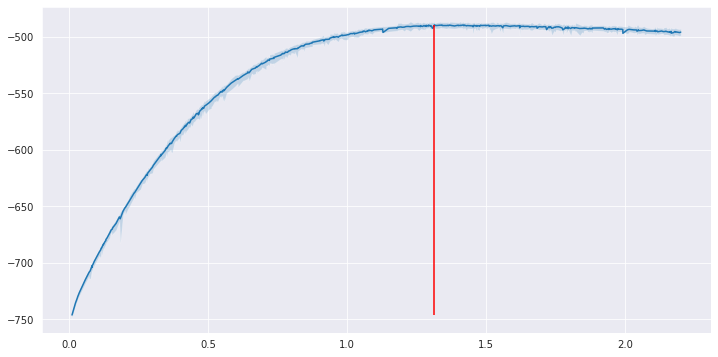

In [473]:
a = .95
log_lik = -kl_sorted
fig, ax = plt.subplots(figsize=(12,6))
l_quant = np.quantile(log_lik, 1-a, axis=1)
log_lik_mean = np.mean(log_lik, axis=1)
r_quant = np.quantile(log_lik, a, axis=1)
ax.plot(norm_sorted, log_lik_mean)
ax.fill_between(norm_sorted, l_quant, r_quant, alpha=0.2)
idx_min = np.argmax(log_lik_mean)
plt.vlines(norm_sorted[idx_min], ymin=min(log_lik_mean), ymax=max(log_lik_mean), color='r')
# plt.xscale('log')
plt.savefig("./plots/marginal_log_lik.png", dpi=200)
plt.show()

In addition: Warning message:
In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages


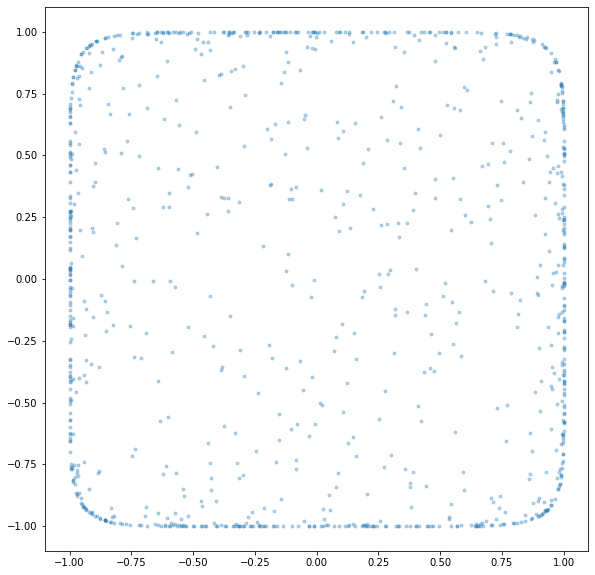

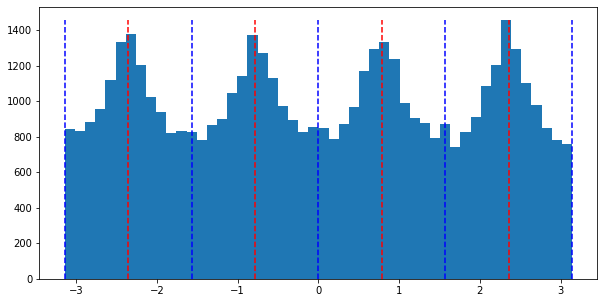

In [485]:
from rpy2.robjects.packages import importr
flow_dim = 3
rpgnorm = importr('pgnorm')
%R -i q -i flow_dim -i n_samples -o samples samples <- rpgnorm(n_samples * flow_dim, q)
samples = np.array(samples).reshape(-1,flow_dim)
samples_norm = lp_norm(samples, q)
plt.figure(figsize=(10,10))
plt.scatter(samples_norm[:n_samples_plot,0], samples_norm[:n_samples_plot,1], marker='.', alpha=0.3)
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.savefig(f"{dir_name}samples_p{q}_gt.pdf", dpi=100)
plt.show()

plt.figure(figsize=(10,5))
theta_ = theta_given_x_y(samples_norm)
n, bins, patches = plt.hist(theta_, bins=50)
plt.vlines([-np.pi * 0.75, -np.pi * 0.25, np.pi * 0.25, np.pi * 0.75], ymin=0, ymax=max(n), linestyles='dashed', colors='r')
plt.vlines([-np.pi, -np.pi * 0.5, 0, np.pi * 0.5, np.pi], ymin=0, ymax=max(n), linestyles='dashed', colors='b')
plt.savefig(f"{dir_name}samples_p{q}_theta_gt.pdf", dpi=100)
plt.show()